# Parse Data sources and train test split

In [2]:
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from pandas import read_csv 
from pandas import DataFrame
from pandas import concat
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import os
from gcnn_pkg import *
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import csv

scaler = MinMaxScaler(feature_range=(-1, 1))
values = scaler.fit_transform(values_origin)
rr = scaler.inverse_transform(test_X[0, :, :])[:,:2]

hours_pred = [10, 11, 12, 13, 14, 15, 16, 17]
train_ratio = 0.8

def random_train_test_dates(Data_ary, Label, test_size=.2, random_state=332):
    dates = {}
    for day in Label['Time'].dt.date:
        if day not in dates:
            dates[day] = 1
    dates_ary = dates.keys()
    train, test = train_test_split(dates_ary, test_size=test_size, random_state=random_state)
    Train_data = []
    Test_data = []
    for Data in Data_ary:
        train_data = Data.loc[(Data['Time'].dt.date.isin(train)), Data.columns].drop(['Time'], axis=1)
        test_data = Data.loc[(Data['Time'].dt.date.isin(test)), Data.columns].drop(['Time'], axis=1)
        Train_data.append(train_data)
        Test_data.append(test_data)
    train_Label = Label.loc[(Data['Time'].dt.date.isin(train)), Label.columns].drop(['Time'], axis=1)
    test_Label = Label.loc[(Data['Time'].dt.date.isin(test)), Label.columns].drop(['Time'], axis=1)
    test_timestamp = Label.loc[(Data['Time'].dt.date.isin(test)), ['Time']]
    return Train_data, Test_data, train_Label, test_Label, test_timestamp

def augmentation(data, folds, sigma):
    output = data.copy()
    D = output.shape[-1]
    col_std  = list()
    for d in range(D):
        col_std.append(np.std(output.iloc[:,d])*sigma)
    for idx in range(folds):
        tmp = data.copy()
        for d in range(D):
            tmp.iloc[:,d] += np.random.normal(0, col_std[d], data.shape[0])
        output = np.append(output, tmp, axis=0)
    return pd.DataFrame(output)

weather = read_csv('weather_feature.csv')
spd = read_csv('spd_features.csv')
parking = read_csv('parking_feature_win.csv')
Y = read_csv('Y_win.csv')

weather['Time'] = pd.to_datetime(weather['Time'], format= "%m/%d/%y %H:%M")
spd['Time'] = pd.to_datetime(spd['Time'], format= "%m/%d/%y %H:%M")
parking['Time'] = pd.to_datetime(parking['Time'], format= "%m/%d/%y %H:%M")
weather['Time'] = pd.to_datetime(weather['Time'], format= "%m/%d/%y %H:%M")
Y['Time'] = pd.to_datetime(Y['Time'], format= "%m/%d/%y %H:%M")

## Train test data
Train_data, Test_data, train_Label, test_Label, test_timestamp = random_train_test_dates([parking, spd, weather], Y, test_size=.2, random_state=332)
[parking, spd, weather] = Train_data
[parking_test, spd_test, weather_test] = Test_data
Y = train_Label
folds = 3
[parking, spd, weather] = [augmentation(parking, folds, 0.05), augmentation(spd, folds, 0.05), augmentation(weather, folds, 0.05)]
Y = augmentation(train_Label, folds, 0.05)

Y_test = test_Label
## Dist matrix
L = torch.autograd.Variable(torch.FloatTensor(np.genfromtxt(os.path.join("", 'L.csv'),delimiter=',')))
V = L.size()[0]

#Create a normalizer
nl = normalizers()

In [3]:
# wins all parking
parking = read_csv('parking_feature.csv')
wins_mins = list()
wins_maxs = list()
wins_lower = 0
wins_upper = 95

parking_win = parking.copy()
D = parking_win.shape[-1]
for d in range(1, D, 1):
    tmp_X = parking_win.iloc[:,d]
    wins_mins.append(np.percentile(tmp_X, wins_lower))
    wins_maxs.append(np.percentile(tmp_X, wins_upper))
print parking_win.shape, len(wins_maxs)
for d in range(1, D, 1):
    parking_win.iloc[:,d] = np.clip(parking_win.iloc[:,d], 0, (wins_maxs[d-1])).astype(int)
parking_win.to_csv("parking_feature_win.csv", index=False)


In [4]:
name = 'weather'
D = weather.shape[1]  # dimension for this dataset
num_hidden = 20  # since we use linear + relu + linear, this is imtermidate dimension
num_output = 30  # output dimension ##############
config = {'name' : name, 'D': D, 'num_hidden':num_hidden, 'num_output': num_output}

weather_X = torch.autograd.Variable(torch.FloatTensor(weather.values))

# normalize
weather_norm_list = ['wins']
nl.build_normalizer(name, weather_norm_list, weather_X)

#train
new_weather_X = nl.transform(name, weather_X)
weather_data = one_dateset(new_weather_X, name, 'D', config)

#test
weather_X_test = torch.autograd.Variable(torch.FloatTensor(weather_test.values))
new_weather_X_test = nl.transform(name, weather_X_test)
weather_data_test = one_dateset(new_weather_X_test, name, 'D', config)

/usr/local/lib/python2.7/dist-packages/numpy/lib/function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [5]:
name = 'parking'
T = 5
parking_ntvd = DataFrame.as_matrix(parking).reshape((parking.shape[0], 5, parking.shape[1]/5, 1))
parking_nvtd = np.swapaxes(parking_ntvd,1,2)
num_layer = 2
D = 1
F = 3
K = 3
C = 1
O = 1
num_hidden = 6 # output dimension after graph cnn
num_output = 10 # final output dimension after LSTM, per node
dropoutLSTM = 0.0
config = {'name' : name, 'T': T, 'num_layer': num_layer, 
                  'D': D, 'V':V, 'L': L, 'F': F, 'K': K, 'C': C, 'O': O,
                'num_output' : num_output, 'num_hidden' : num_hidden, 'dropoutLSTM': dropoutLSTM}

parking_X = torch.autograd.Variable(torch.FloatTensor(parking_nvtd))

# normalize
parking_norm_list = ['std', 'minmax']
nl.build_normalizer(name, parking_norm_list, parking_X)

# train
new_parking_X = nl.transform(name, parking_X)
parking_data = one_dateset(new_parking_X, name, 'VTD', config)

# test
parking_ntvd_test = DataFrame.as_matrix(parking_test).reshape((parking_test.shape[0], 5, parking_test.shape[1]/5, 1))
parking_nvtd_test =np.swapaxes(parking_ntvd_test,1,2)
parking_X_test = torch.autograd.Variable(torch.FloatTensor(parking_nvtd_test))
new_parking_X_test = nl.transform(name, parking_X_test)
parking_data_test = one_dateset(new_parking_X_test, name, 'VTD', config)

In [6]:
name = 'spd'
D = spd.shape[1]  # dimension for this dataset
num_hidden = 128  # since we use linear + relu + linear, this is imtermidate dimension
num_output = 32  # output dimension ##############
config = {'name' : name, 'D': D, 'num_hidden':num_hidden, 'num_output': num_output}

spd_X = torch.autograd.Variable(torch.FloatTensor(spd.values))
# normalize
spd_norm_list = [ 'minmax']
nl.build_normalizer(name, spd_norm_list, spd_X)

#Train
new_spd_X = nl.transform(name, spd_X)
spd_data = one_dateset(new_spd_X, name, 'D', config)

#test
spd_X_test = torch.autograd.Variable(torch.FloatTensor(spd_test.values))
new_spd_X_test = nl.transform(name, spd_X_test)
spd_data_test = one_dateset(new_spd_X_test, name, 'D', config)

In [7]:
name = 'y'
y = torch.autograd.Variable(torch.FloatTensor(Y.values)).unsqueeze(2)
y_norm_list = ['wins', 'std', 'wins', 'minmax']
nl.build_normalizer(name, y_norm_list, y)
new_y = nl.transform(name, y).squeeze(2)
y_test = torch.autograd.Variable(torch.FloatTensor(Y_test.values)).unsqueeze(2)
new_y_test = nl.transform(name, y_test).squeeze(2)

name = 'y'
y_norm_list = ['std']
# y_norm_list = ['wins', 'std', 'minmax']

#train
Y_col = Y.columns
y = torch.autograd.Variable(torch.FloatTensor(Y.values)).unsqueeze(2)
nl.build_normalizer(name, y_norm_list, y)
new_y = nl.transform(name, y).squeeze(2)
# new_y = y
#test
y_test = torch.autograd.Variable(torch.FloatTensor(Y_test.values)).unsqueeze(2)
new_y_test = nl.transform(name, y_test).squeeze(2)
# new_y_test = y_test
bias_fix = 2./2.44

In [8]:
after_config = {'num_hidden' : 1024}
 
td_train = traffic_datesets()
# td_train.register_dateset(weather_data)
td_train.register_dateset(parking_data)
td_train.register_dateset(spd_data)
td_train.register_target(new_y)

td_test = traffic_datesets()
# td_test.register_dateset(weather_data_test)
td_test.register_dateset(parking_data_test)
td_test.register_dateset(spd_data_test)
td_test.register_target(new_y_test)

# Training with default hyperparameters

In [ ]:
train_set = td_train
test_set = td_test
batch_size = 128
num_epoch = 30
learning_rate = 0.01
verbose = True
use_GPU = True
dropout_rate = 0.0

if use_GPU:
    train_set.to_cuda()
    test_set.to_cuda()

config_list = train_set.generate_config_list()
model = parking_prediction(new_y.shape[1], config_list, after_config, dropout_rate)

if use_GPU:
    model = model.cuda()
    for name, embedding in model.embedding_dict.iteritems():
        model.embedding_dict[name] = embedding.cuda()

optimizer = torch.optim.Adam(model.get_all_parameters(), lr = learning_rate)
loss_fn = torch.nn.MSELoss(reduce=False)
total_train = train_set.get_num_data()
model.train()
#
record = [list(), list()]
# record[0].append(loss_fn(model(train_set.get_data_list()), train_set.get_y()).cpu().data.numpy()[0])
# record[1].append(loss_fn(model(test_set.get_data_list()), test_set.get_y()).cpu().data.numpy()[0])
lowest_loss = 20
for i in range(num_epoch):
    total_train_loss = 0.0
    model.train()
    seq = np.random.permutation(total_train)
    train_sample_list = np.array_split(seq, len(seq) / batch_size)
    for sample_ind in train_sample_list:
        t_sample_ind = torch.LongTensor(sample_ind)
        if use_GPU:
            t_sample_ind = t_sample_ind.cuda()
        sample_x = train_set.get_data_list(t_sample_ind)
        sample_y = train_set.get_y(t_sample_ind)
        predicted_y = model.forward(sample_x)
        loss = torch.sum(loss_fn(predicted_y, sample_y).cuda(), dim=0)
        total_train_loss += loss.data.cpu().numpy()[0]
        loss = (loss_fn(predicted_y, sample_y).cuda())
        optimizer.zero_grad()
        loss.backward(torch.FloatTensor(np.ones(loss.shape)).cuda())
        optimizer.step()
    model.eval()
    train_loss = np.mean(total_train_loss / len(seq))
    test_loss = np.mean(loss_fn(model(test_set.get_data_list()), test_set.get_y()).cpu().data.numpy()[0])
    y_1 = nl.reverse('y', model(test_set.get_data_list()).unsqueeze(2)).squeeze(2).cpu().data.numpy().clip(0, )
    y_2 = nl.reverse('y', (test_set.get_y().unsqueeze(2))).squeeze(2).cpu().data.numpy()
    actual_loss = mean_squared_error(y_1, y_2)
#     lowest_loss = np.min([actual_loss, lowest_loss])
    #     y_1 = nl.reverse('y', model(test_set.get_data_list()).unsqueeze(2))
#     y_2 = nl.reverse('y', (test_set.get_y().unsqueeze(2)))
    if verbose:
        print "Epoch ", i, "Training loss: ", train_loss, "Testing loss: ", test_loss, "Norm loss", actual_loss

In [27]:
# street capacity
rd_cap = (train_Label.quantile(0.98)).to_frame()
rd_cap.columns = ['capacity']
rd_cap.index.name = 'block'
print np.mean(rd_cap.values)
print rd_cap.columns
#  Get street-wise error 
model.eval()
y_pre = nl.reverse('y', model(test_set.get_data_list()).unsqueeze(2)).squeeze(2).cpu().data.numpy().clip(0, )
y_tru = nl.reverse('y', (test_set.get_y().unsqueeze(2))).squeeze(2).cpu().data.numpy()
y_preT = np.transpose(y_pre)
y_truT = np.transpose(y_tru)
test_err = []
test_err_percent = []
for i in range(len(y_preT)):
    err = (mean_absolute_error(y_preT[i].clip(0, rd_cap.iloc[i,0]), y_truT[i]))
#     print err
    test_err.append(err)
    test_err_percent.append(np.float(err)/rd_cap.iloc[i,0])
print np.mean(test_err)
print np.mean(test_err_percent)
rd_cap['MAE'] = test_err
rd_cap['MAPE'] = test_err_percent
rd_cap.to_csv('heat_map_GCNN_no_weather.csv')
# print test_err_percent
# print test_timestamp
other_methods = [4.02, 3.17]+ [a*1.1 for a in [4.25, 5.15, 5.61, 6.34, 4.27, 4.63, 11.48, 11.51, 8.99, 9.29]]
print np.sqrt(other_methods)/2*np.mean(test_err)

14.256410256410257
Index([u'capacity'], dtype='object')
1.7409394
0.13336169807169732
[1.7452863  1.54982722 1.88210765 2.07182758 2.16237706 2.29876526
 1.88653094 1.96444779 3.09329215 3.09733127 2.73734692 2.78264531]


## Process Regression results

In [88]:
import numpy as np
from operator import add

# print float(rd_cap.loc['oneCHATH'])
def random_train_test_dates_lasso(Data, Label, test_size=.2, random_state=332):
    dates = {}
    for day in Label['Time'].dt.date:
        if day not in dates:
            dates[day] = 1
    dates_ary = dates.keys()
    train, test = train_test_split(dates_ary, test_size=test_size, random_state=random_state)
    train_data = Data.loc[(Data['Time'].dt.date.isin(train)), Data.columns].drop(['Time'], axis=1)
    test_data = Data.loc[(Data['Time'].dt.date.isin(test)), Data.columns].drop(['Time'], axis=1)
    train_Label = Label.loc[(Data['Time'].dt.date.isin(train)), Label.columns].drop(['Time'], axis=1)
    test_Label = Label.loc[(Data['Time'].dt.date.isin(test)), Label.columns].drop(['Time'], axis=1)
    return train_data, test_data, train_Label, test_Label
from sklearn import linear_model
hours_pred = [10, 11, 12, 13, 14, 15, 16, 17]
train_ratio = 0.75
weather = read_csv('weather_feature.csv')
spd = read_csv('spd_features.csv')
parking = read_csv('parking_feature.csv')
Y = read_csv('Y.csv')

weather['Time'] = pd.to_datetime(weather['Time'], format= "%m/%d/%y %H:%M")
spd['Time'] = pd.to_datetime(spd['Time'], format= "%m/%d/%y %H:%M")
parking['Time'] = pd.to_datetime(parking['Time'], format= "%m/%d/%y %H:%M")
weather['Time'] = pd.to_datetime(weather['Time'], format= "%m/%d/%y %H:%M")
Y['Time'] = pd.to_datetime(Y['Time'], format= "%m/%d/%y %H:%M")
spd = spd.drop(['Time'], axis=1)
Data = (pd.concat([parking, spd], axis=1))

In [ ]:
# street capacity
rd_cap = (train_Label.quantile(0.98)).to_frame()
rd_cap.columns = ['capacity']
rd_cap.index.name = 'block'

# LASSO
errors = []
errors_train = []
errors_mape = []
linktotal = np.zeros(38)
for Link_id in Y.columns[1:]:
    y = Y[['Time', str(Link_id)]]
    train_X, test_X, train_y, test_y = random_train_test_dates_lasso(Data, y, test_size=.2, 
                                                                     random_state=1)
    model=linear_model.Lasso(alpha=0.000).fit(train_X, train_y)
    err = mean_absolute_error(model.predict(test_X), test_y)
    errors.append(err)
    errors_mape.append(np.float(err/rd_cap.loc[Link_id]))
    errors_train.append(mean_absolute_error(model.predict(train_X), train_y))
#     break
#     print model.score(train_X, train_y), model.score(test_X, test_y)
print errors
print ("LASSO train MAE, test MAE, MAPE:", np.mean(errors_train), np.mean(errors), np.mean(errors_mape))
# print pktotal, spdtotal
# print linktotal
rd_cap['MAE'] = errors
rd_cap['MAPE'] = errors_mape
rd_cap.to_csv('heat_map_LASSO_test.csv')

In [ ]:
rd_cap = (train_Label.quantile(0.98)).to_frame()
rd_cap.columns = ['capacity']
rd_cap.index.name = 'block'
### HA
errors = []
errors_train = []
errors_mape = []
for Link_id in Y.columns[1:]:
    y = Y[['Time', str(Link_id)]]
    train_X, test_X, train_y, test_y = random_train_test_dates_lasso(Data, y, test_size=.2, random_state=332)
    pre = np.average(test_X.loc[:, Link_id+"_1"])
    error = mean_absolute_error(np.repeat(pre, test_y.shape[0]), test_y)
    errors.append(error)
    errors_mape.append(np.float(error/rd_cap.loc[Link_id]))
    errors_train.append(mean_absolute_error(np.repeat(pre, train_y.shape[0]), train_y))
#     print model.score(train_X, train_y), model.score(test_X, test_y)
print ("HA errors: ", np.mean(errors_train), np.mean(errors), np.mean(errors_mape))

### Last
errors = []
errors_train = []
errors_mape = []
for Link_id in Y.columns[1:]:
    y = Y[['Time', str(Link_id)]]
    train_X, test_X, train_y, test_y = random_train_test_dates_lasso(Data, y, test_size=.2, random_state=332)
    error = mean_absolute_error(test_X.loc[:, Link_id+"_2"], test_y)
    errors.append(error)
    errors_mape.append(np.float(error/rd_cap.loc[Link_id]))
    errors_train.append(mean_absolute_error(train_X.loc[:, Link_id+"_2"], train_y))
#     print model.score(train_X, train_y), model.score(test_X, test_y)
print ("Last mse: ", np.mean(errors_train), np.mean(errors), np.mean(errors_mape))

In [ ]:
ofile_a = open('training_log.csv', 'a')
writer_a = csv.writer(ofile_a, delimiter=',', lineterminator='\n', dialect='excel')
writer_a.writerow(["lowest_loss", "num_hidden_parking", "num_output_parking", "num_layer_parking", 
                   "dropoutLSTM", "num_hidden_spd", "num_output_spd","num_hidden_after","dropout_rate"])
ofile_a.flush()
# ofile_a.close()


# Grid search for hyper-parameter tuning

In [ ]:
for (num_hidden_parking, num_output_parking) in [(4, 6), (6, 10), (8, 12)]:
    for (num_layer_parking, dropoutLSTM) in [(2, 0.0), (3, 0.0), (4, 0.0), (5, 0.5)]:
        for (num_hidden_spd, num_output_spd) in [(128, 32), (256, 32), (512, 64), (512, 32)]:
            for num_hidden_after in [512, 1024, 2048]:
                for dropout_rate in [0.0]:
#                     tmp = find_best_model(num_hidden_parking, num_output_parking, num_layer_parking,dropoutLSTM, num_hidden_spd, num_output_spd,num_hidden_after,dropout_rate)
                    try:
                        tmp = find_best_model(num_hidden_parking, num_output_parking, num_layer_parking,dropoutLSTM, num_hidden_spd, num_output_spd,num_hidden_after,dropout_rate)
                        writer_a.writerow([str(i) for i in tmp])
                        ofile_a.flush()
                    except:
                        continue
ofile_a.close()

In [ ]:
## Find best model-fine-grain
ofile_a = open('training_log_kfo_only.csv', 'a')
writer_a = csv.writer(ofile_a, delimiter=',', lineterminator='\n', dialect='excel')
writer_a.writerow(["lowest_loss", "num_hidden_parking", "num_output_parking", "num_layer_parking", 
                   "dropoutLSTM", "num_hidden_spd", "num_output_spd","num_hidden_after","dropout_rate",
                   'K', 'F', 'O'])
ofile_a.flush()
(num_hidden_parking, num_output_parking) = (8, 16)
(num_layer_parking, dropoutLSTM) = (4, 0.0)
(num_hidden_spd, num_output_spd) = (512, 32)
num_hidden_after = 1024
dropout_rate = 0.0
for F in [3,4,5]:
    for K in [3,4,5,6]:
        for O in [2,3,4]:
            try:
                tmp = find_best_model(num_hidden_parking, num_output_parking, num_layer_parking,dropoutLSTM, 
                                              num_hidden_spd, num_output_spd,num_hidden_after,dropout_rate, K, F, O)
                writer_a.writerow([str(i) for i in tmp])
                ofile_a.flush()
            except:
                continue
ofile_a.close()

In [ ]:
## Find best model-5 folds
ofile_a = open('training_log_kfo.csv', 'a')
writer_a = csv.writer(ofile_a, delimiter=',', lineterminator='\n', dialect='excel')
writer_a.writerow(["lowest_loss", "num_hidden_parking", "num_output_parking", "num_layer_parking", 
                   "dropoutLSTM", "num_hidden_spd", "num_output_spd","num_hidden_after","dropout_rate",
                   'K', 'F', 'O'])
ofile_a = open('training_log_kfo.csv', 'a')
writer_a = csv.writer(ofile_a, delimiter=',', lineterminator='\n', dialect='excel')

(num_hidden_parking, num_output_parking) = (8, 16)
(num_layer_parking, dropoutLSTM) = (4, 0.0)
(num_hidden_spd, num_output_spd) = (512, 32)
num_hidden_after = 1024
dropout_rate = 0.0
(K, F, O) = (3, 5, 2)
for num_hidden_after in [256, 512]:
    for num_hidden_parking in [4, 6, 8]:
        for num_output_parking in [4, 6, 8, 10]:
            try:
                tmp = find_best_model(num_hidden_parking, num_output_parking, num_layer_parking,dropoutLSTM, 
                                              num_hidden_spd, num_output_spd,num_hidden_after,dropout_rate, K, F, O)
                writer_a.writerow([str(i) for i in tmp])
                ofile_a.flush()
            except:
                continue
ofile_a.close()

# Try different data preprocessing pipeline

In [ ]:
a = ['wins', 'std', 'minmax']
b = ['minmax']
c = ['wins']
d = ['std', 'minmax']
e = ['std', 'wins']
(num_hidden_parking, num_output_parking) = (8, 16)
(num_layer_parking, dropoutLSTM) = (4, 0.0)
(num_hidden_spd, num_output_spd) = (512, 32)
num_hidden_after = 1024
dropout_rate = 0.0
(K, F, O) = (3, 5, 2)
tmp = find_best_model(num_hidden_parking, num_output_parking, num_layer_parking,dropoutLSTM, 
                                                  num_hidden_spd, num_output_spd,num_hidden_after,dropout_rate, 
                                          K, F, O)

In [ ]:
## Find best model-5 folds w norm
ofile_a = open('training_log_norm.csv', 'w')
writer_a = csv.writer(ofile_a, delimiter=',', lineterminator='\n', dialect='excel')
writer_a.writerow(["lowest_loss", "num_hidden_parking", "num_output_parking", "num_layer_parking", 
                   "dropoutLSTM", "num_hidden_spd", "num_output_spd","num_hidden_after","dropout_rate",
                   'K', 'F', 'O',"parking_norm_list", "y_norm_list"])
ofile_a.flush()
a = ['wins', 'std', 'minmax']
b = ['minmax']
c = ['wins']
d = ['std', 'minmax']
e = ['std']
(num_hidden_parking, num_output_parking) = (8, 16)
(num_layer_parking, dropoutLSTM) = (4, 0.0)
(num_hidden_spd, num_output_spd) = (512, 32)
num_hidden_after = 1024
dropout_rate = 0.0
(K, F, O) = (3, 5, 2)
for num_hidden_parking in [4, 6, 8]:
    for num_output_parking in [4, 8, 10]:
        for parking_norm_list in [b, d, e]:
            for y_norm_list in [b, d, e]:
                tmp = find_best_model(num_hidden_parking, num_output_parking, num_layer_parking,dropoutLSTM, 
                                                  num_hidden_spd, num_output_spd,num_hidden_after,dropout_rate, 
                                          K, F, O, parking_norm_list, y_norm_list)
                writer_a.writerow([str(i) for i in tmp])
                ofile_a.flush()
ofile_a.close()

In [ ]:
## Output training progress:
d = ['std', 'minmax']
e = ['std']
(num_hidden_parking, num_output_parking) = (6, 10)
(num_layer_parking, dropoutLSTM) = (4, 0.0)
(num_hidden_spd, num_output_spd) = (512, 32)
num_hidden_after = 1024
dropout_rate = 0.0
parking_norm_list = e
y_norm_list = d
(K, F, O) = (3, 4, 2)
tmp = find_best_model([1,1], num_hidden_parking, num_output_parking, num_layer_parking,dropoutLSTM, 
                                                  num_hidden_spd, num_output_spd,num_hidden_after,dropout_rate, 
                                          K, F, O, parking_norm_list, y_norm_list)

In [ ]:
a = ['wins', 'std', 'minmax']
b = ['minmax']
c = ['wins']
d = ['std', 'minmax']
e = ['std', 'wins']
(num_hidden_parking, num_output_parking) = (8, 16)
(num_layer_parking, dropoutLSTM) = (4, 0.0)
(num_hidden_spd, num_output_spd) = (512, 32)
num_hidden_after = 1024
dropout_rate = 0.0
(K, F, O) = (3, 5, 2)
result = {}
for ds in [[1,1],[1,0], [0,1],[0,0]]:
    torch.cuda.empty_cache()
    tmp = find_best_model(ds, num_hidden_parking, num_output_parking, num_layer_parking,dropoutLSTM, 
                                                      num_hidden_spd, num_output_spd,num_hidden_after,dropout_rate, 
                                              K, F, O)
    result[",".join([str(s) for s in ds])] = tmp

In [13]:
ofile_a = open('training_log_combinataion.csv', 'w')
writer_a = csv.writer(ofile_a, delimiter=',', lineterminator='\n', dialect='excel')
writer_a.writerow(["epoch", "11Train", "11test", "10Train", 
                   "10test", "01Train", "01test","00train","00test"])
length = len(result["1,1"][1][1])
for i in range(length):
    writer_a.writerow([str(k) for k in [i, result["1,1"][1][0][i], result["1,1"][1][1][i], result["1,0"][1][0][i], 
                                        result["1,0"][1][1][i], result["0,1"][1][0][i], result["0,1"][1][1][i],
                                        result["0,0"][1][0][i], result["0,0"][1][1][i]]])
ofile_a.close()

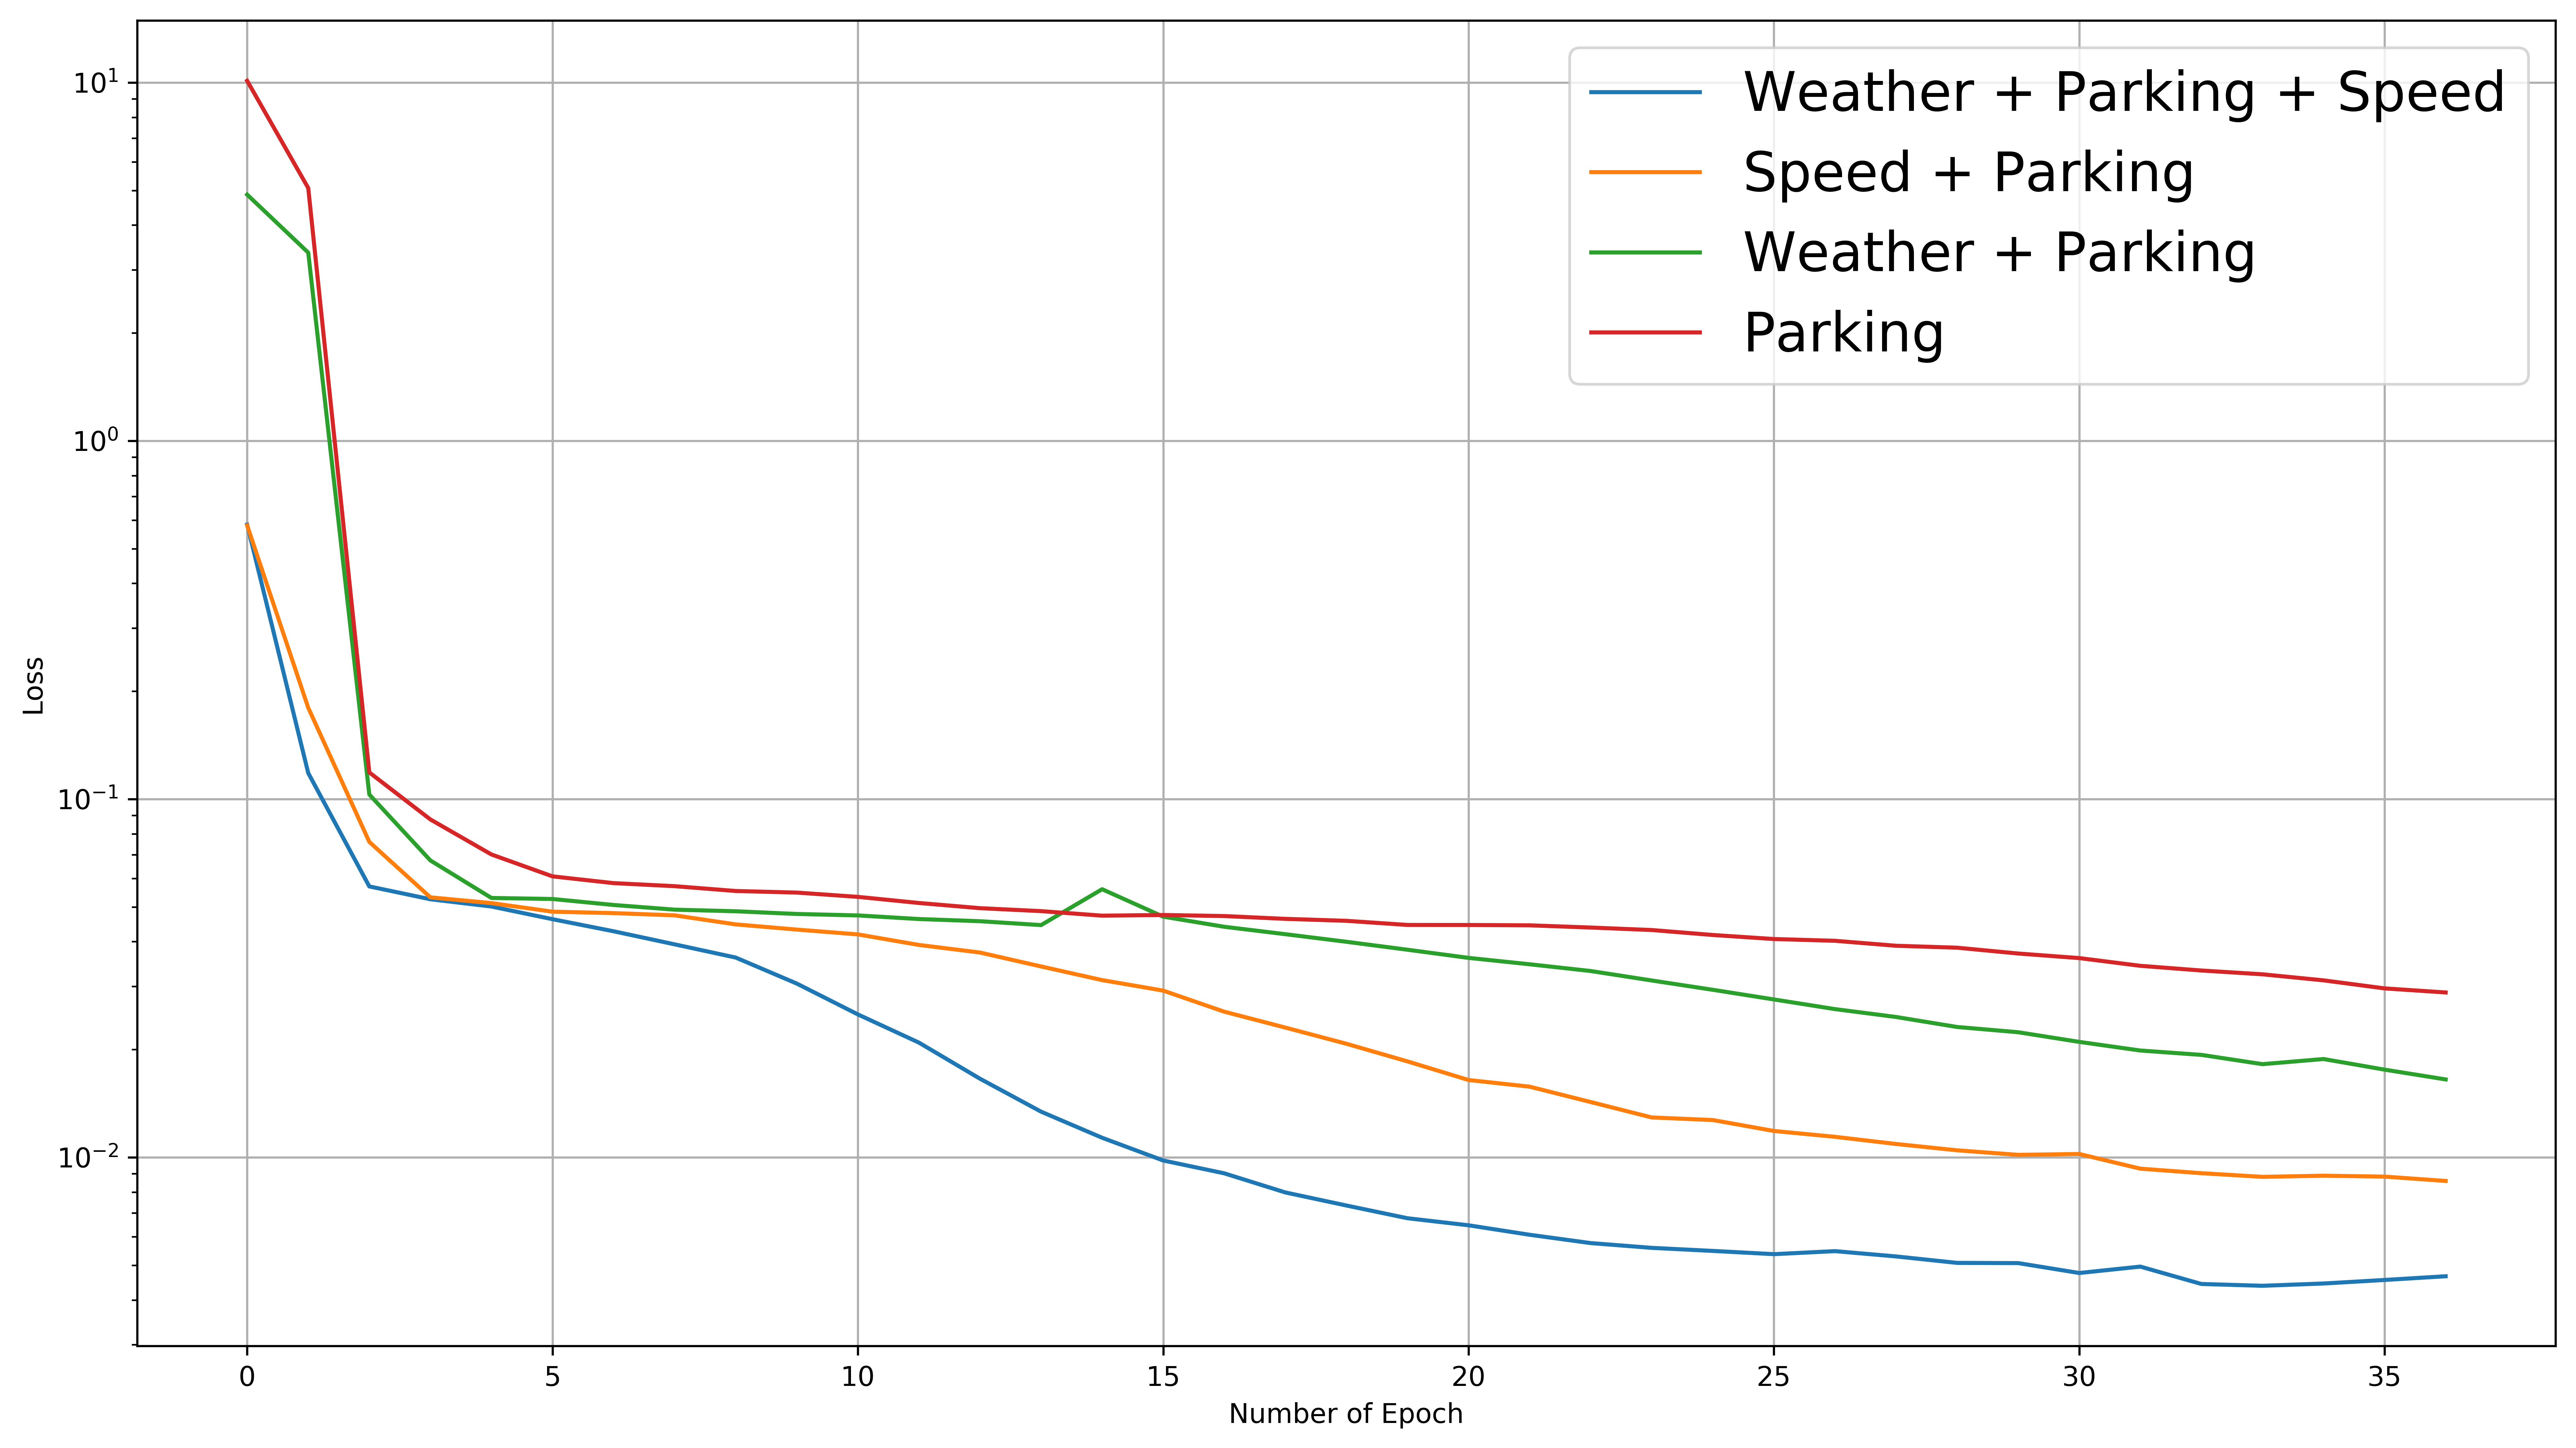

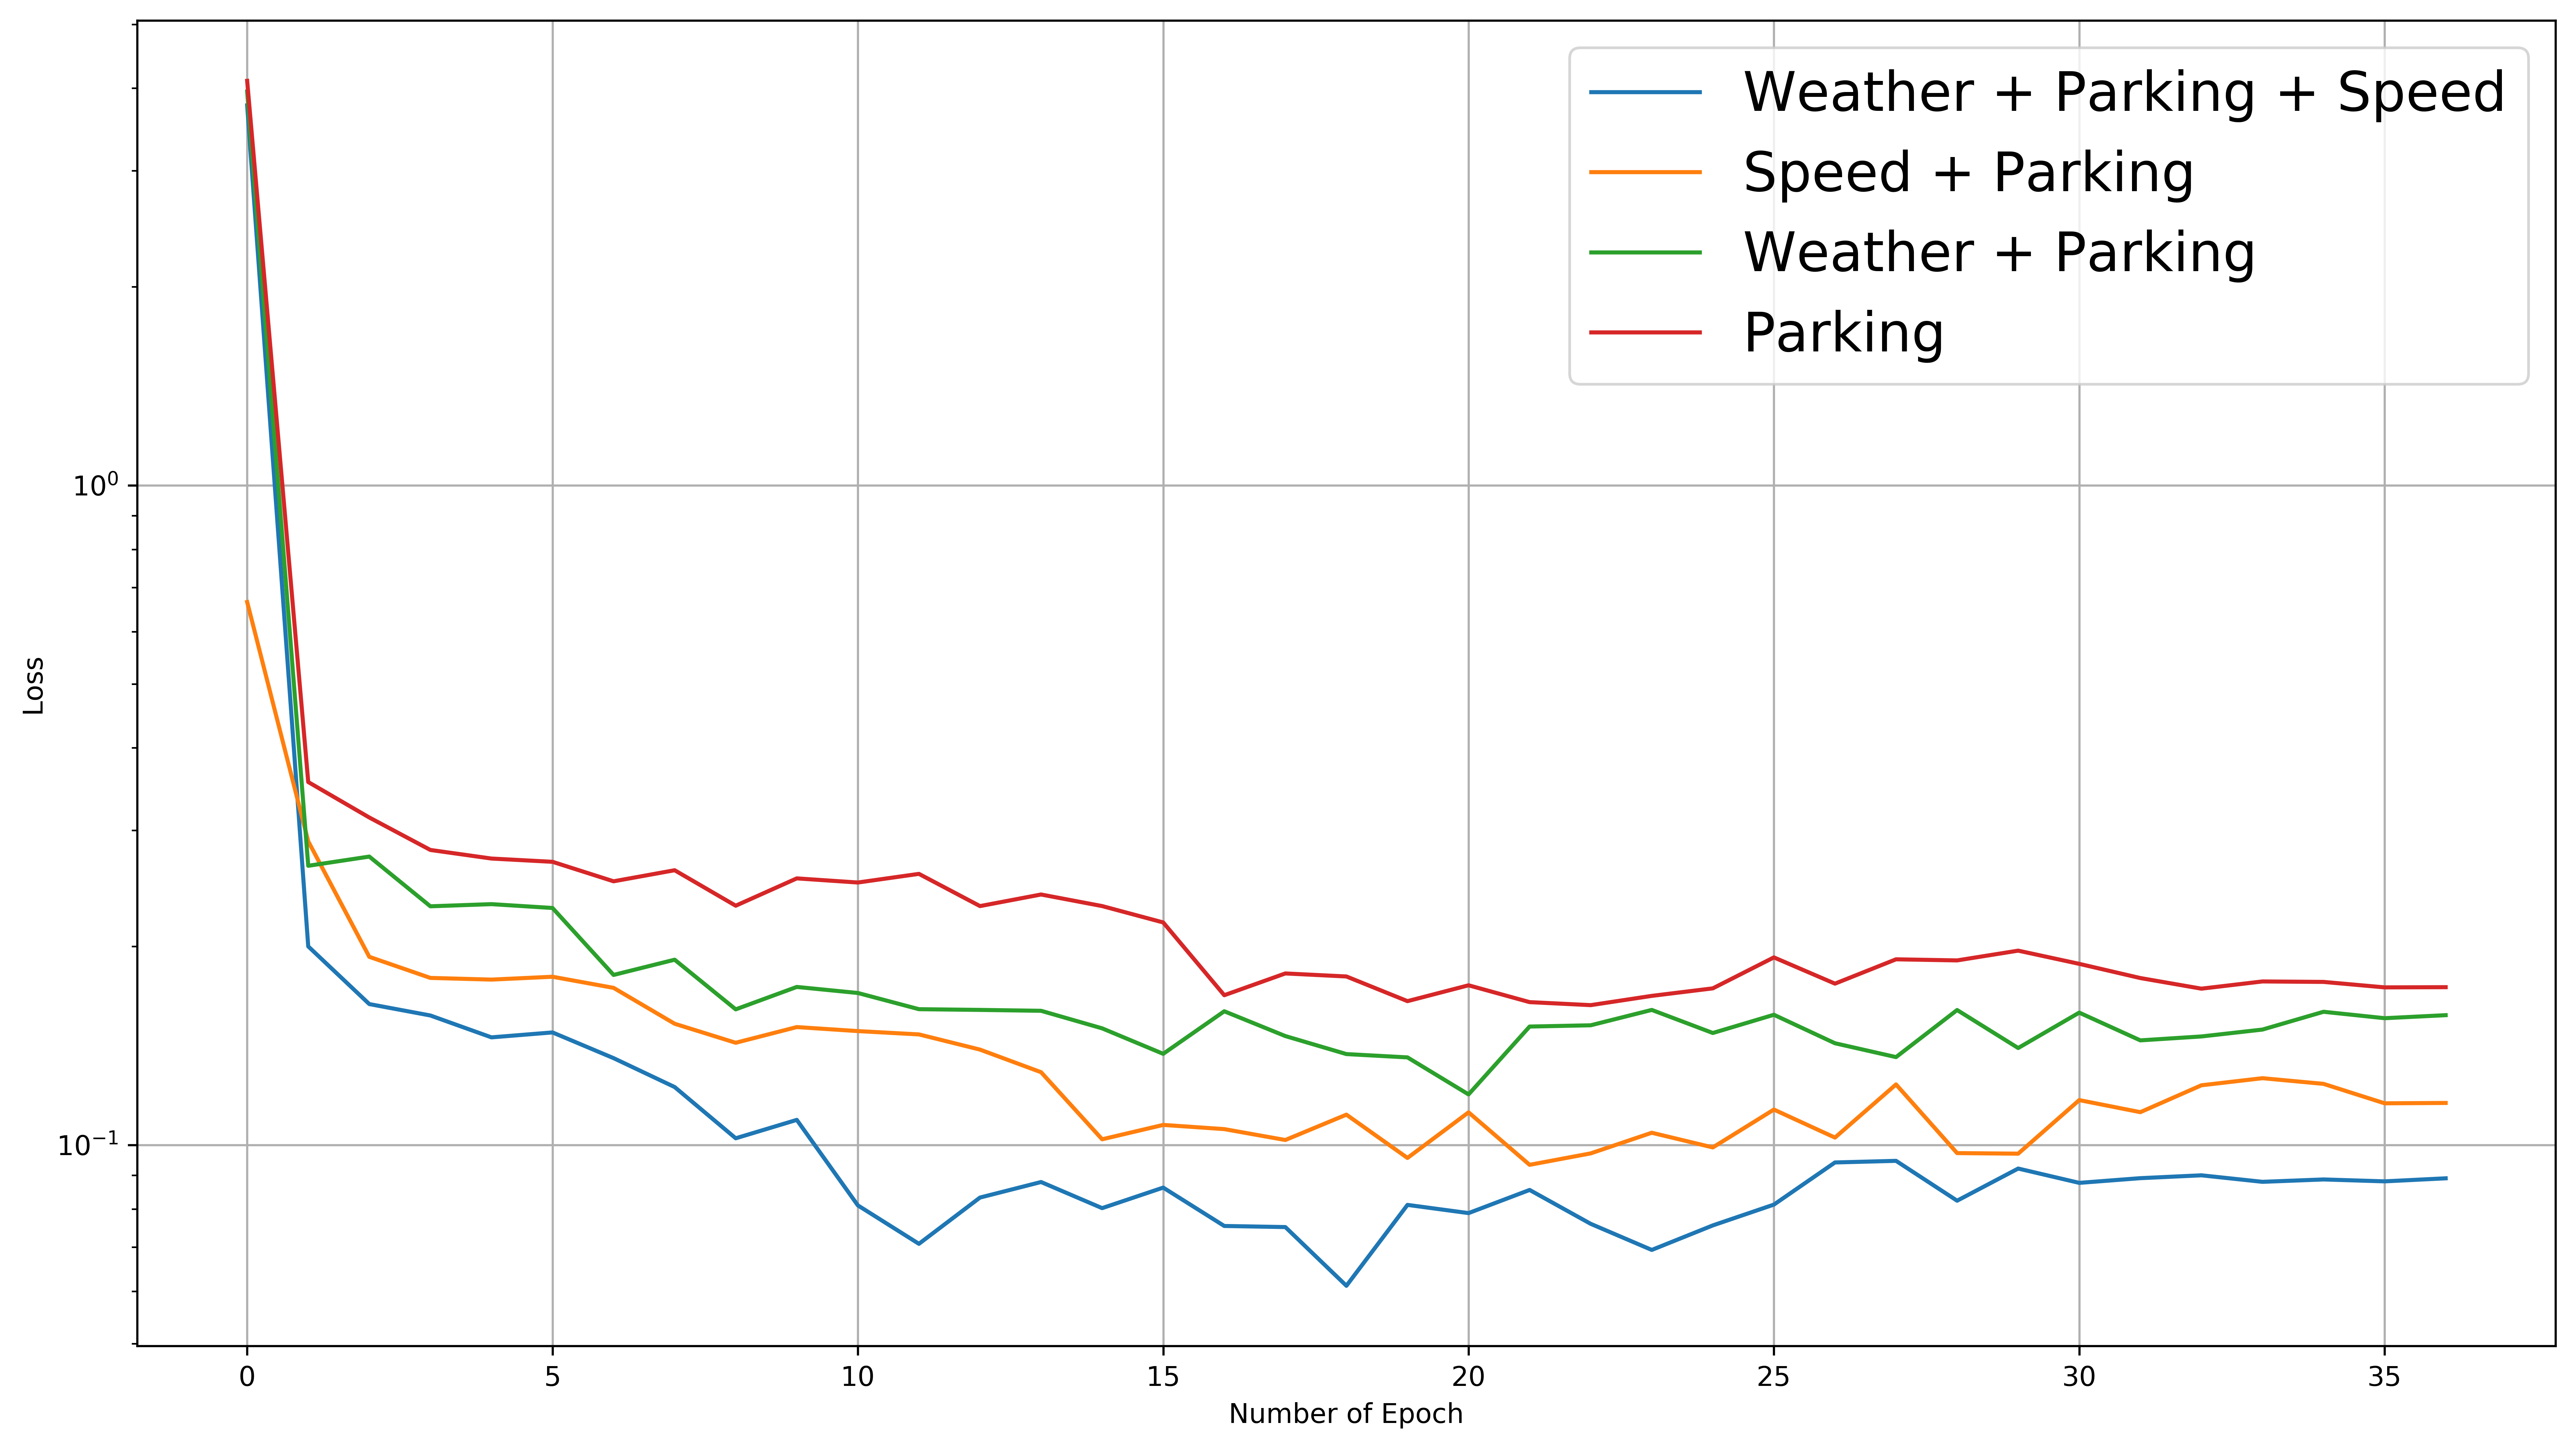

In [37]:
logs = pd.read_csv("training_log_new.csv")

plt.figure(figsize = (16,9), dpi = 600)

plt.semilogy(np.array(np.array(logs['11Train'])), label = 'Weather + Parking + Speed')
plt.semilogy(np.array(np.array(logs['10Train'])), label = 'Speed + Parking')
plt.semilogy(np.array(np.array(logs['01Train'])), label = 'Weather + Parking')
plt.semilogy(np.array(np.array(logs['00Train'])), label = 'Parking')

plt.grid(True)
plt.xlabel('Number of Epoch')
plt.ylabel('Loss')
plt.legend(loc=1, prop={'size': 20})
plt.show()

plt.figure(figsize = (16,9), dpi = 600)
plt.semilogy(np.array(np.array(logs['11test'])), label = 'Weather + Parking + Speed')
plt.semilogy(np.array(np.array(logs['10test'])), label = 'Speed + Parking')
plt.semilogy(np.array(np.array(logs['01test'])), label = 'Weather + Parking')
plt.semilogy(np.array(np.array(logs['00test'])), label = 'Parking')

plt.grid(True)
plt.xlabel('Number of Epoch')
plt.ylabel('Loss')
plt.legend(loc=1, prop={'size': 20})
plt.show()